In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import time
import itertools
from tensorflow.keras.datasets.cifar10 import load_data

### Data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
train_data = {
    'X': x_train,
    'y': y_train
}
val_data = {
    'X': x_val,
    'y': y_val
}
test_data = {
    'X': x_test,
    'y': y_test
}

In [4]:
def get_preprocessed_data(data, batch_size=None):

    images = np.reshape(data['X'], (len(data['y']), 32, 32, 3))
    labels = data['y']

    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
        
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])

    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    if batch_size:
        ds = tf.data.Dataset.from_tensor_slices((images, labels))
        ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    else:
        ds = {'X': images, 'y': labels}

    return ds

val_ds = get_preprocessed_data(val_data)
test_ds = get_preprocessed_data(test_data)
train_ds = get_preprocessed_data(train_data)

In [5]:
print('Trainnig data shape:')
print(train_ds['X'].shape)
print('Valdiation data shape:')
print(val_ds['X'].shape)
print('Test data shape:')
print(test_ds['X'].shape)

Trainnig data shape:
(50000, 32, 32, 3)
Valdiation data shape:
(5000, 32, 32, 3)
Test data shape:
(5000, 32, 32, 3)


In [6]:
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}
class_name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

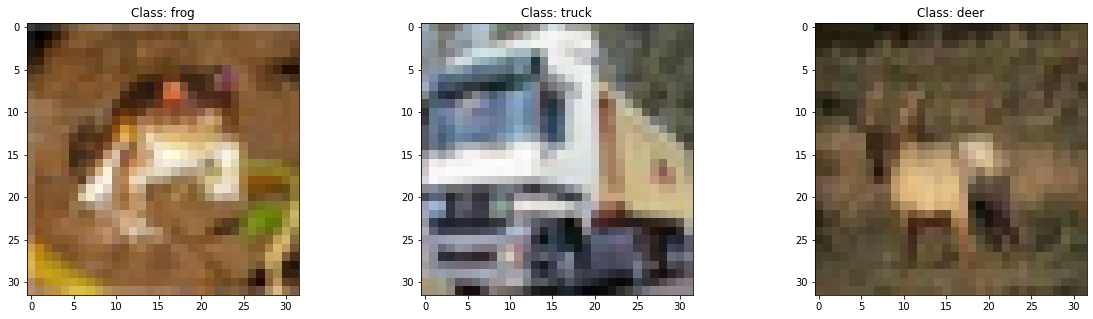

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].imshow(train_ds['X'][0])
axs[0].title.set_text('Class: '+class_name[train_ds['y'][0].numpy()[0]])
axs[1].imshow(train_ds['X'][1])
axs[1].title.set_text('Class: '+class_name[train_ds['y'][1].numpy()[0]])
axs[2].imshow(train_ds['X'][3])
axs[2].title.set_text('Class: '+class_name[train_ds['y'][3].numpy()[0]])

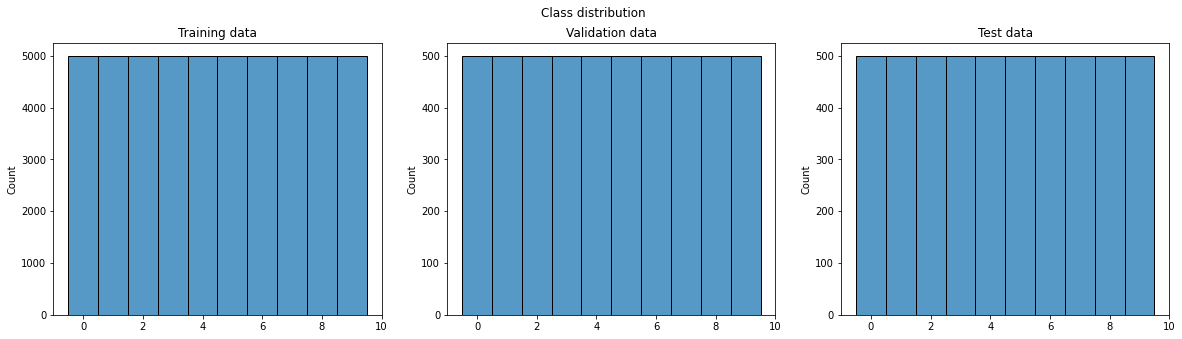

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Class distribution')
sn.histplot(y_train, discrete=True, ax=axs[0])
axs[0].title.set_text('Training data')
axs[0].get_legend().remove()
sn.histplot(y_val, discrete=True, ax=axs[1])
axs[1].title.set_text('Validation data')
axs[1].get_legend().remove()
sn.histplot(y_test, discrete=True, ax=axs[2])
axs[2].title.set_text('Test data')
axs[2].get_legend().remove()

### Models


In [13]:
class Model1:
  def __init__(self):

    self.model = models.Sequential()
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 64)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(384, activation='relu'))
    self.model.add(layers.Dense(192, activation='relu'))
    self.model.add(layers.Dense(14, activation='softmax'))

    self.name = 'Model1'
    self.history = None
    self.params = None


class Model2:
  def __init__(self):

    self.model = models.Sequential()
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 64)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(384, activation='relu'))
    self.model.add(layers.Dropout(.1))
    self.model.add(layers.Dense(192, activation='relu'))
    self.model.add(layers.Dropout(.1))
    self.model.add(layers.Dense(14, activation='softmax'))

    self.name = 'Model2_dropout'
    self.history = None
    self.params = None


class Model3:
  def __init__(self):

    self.model = models.Sequential()
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 64)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(384, activation='relu',  kernel_regularizer='l1'))
    self.model.add(layers.Dense(192, activation='relu',  kernel_regularizer='l1'))
    self.model.add(layers.Dense(14, activation='softmax'))

    self.name = 'Model3_l1'
    self.history = None
    self.params = None


class Model4:
  def __init__(self):

    self.model = models.Sequential()
    self.model.add(layers.DepthwiseConv2D((5, 5), activation='relu', input_shape=(32, 32, 3)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.DepthwiseConv2D((5, 5), activation='relu', input_shape=(32, 32, 64)))
    self.model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(384, activation='relu'))
    self.model.add(layers.Dense(192, activation='relu'))
    self.model.add(layers.Dense(14, activation='softmax'))

    self.name = 'Model4_depthwise'
    self.history = None
    self.params = None

### Helper functions

In [14]:
def print_results(model):
  print('--------MODEL--------')
  print()
  print(model.name)
  print()
  print(model.model.summary())
  print()
  print('Optimizer: ', model.params['optimizer'])
  print('Learning rate: ', model.params['lr'])
  print('Epochs: ', model.params['epochs'])
  print('Batch: ', model.params['batch'])
  print()
  print('Best validation Loss: ', max(model.history.history['val_loss']))
  print('Best validation Accuracy: ', max(model.history.history['val_accuracy']))
  print('Best validation F1Score: ', max(model.history.history['val_f1score']))
  print()


def plot_history(history):
  history = history.history

  epochs = [i+1 for i in range(len(history['loss']))]
  fig, axs = plt.subplots(1, 3, figsize=(20,5))
  axs[0].plot(epochs, history['loss'], label='TRAIN')
  axs[0].plot(epochs, history['val_loss'], label='VALIDATION')
  axs[0].legend()
  axs[0].title.set_text('LOSS')
  axs[0].set_xlabel('EPOCH')
  axs[0].set_ylabel('VALUE')
  axs[1].plot(epochs, history['f1score'], label='TRAIN')
  axs[1].plot(epochs, history['val_f1score'], label='VALIDATION')
  axs[1].legend()
  axs[1].title.set_text('F1 SCORE')
  axs[1].set_xlabel('EPOCH')
  axs[1].set_ylabel('VALUE')
  axs[2].plot(epochs, history['accuracy'], label='TRAIN')
  axs[2].plot(epochs, history['val_accuracy'], label='VALIDATION')
  axs[2].legend()
  axs[2].title.set_text('ACCURACY')
  axs[2].set_xlabel('EPOCH')
  axs[2].set_ylabel('VALUE')
  plt.show()
  

def show_results(model):
  print_results(model)
  plot_history(model.history)
  print()


def get_misclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] != y_pred.numpy()[i] and y_true.numpy()[i] == c]


def get_properclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] == y_pred.numpy()[i] and y_true.numpy()[i] == c]


def plot_misclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_misclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_misclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_misclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_misclasified(c)[2]].numpy()])
    plt.show()
    

def plot_properclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_properclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[0]].numpy()])
    axs[1].imshow(test_ds['X'][get_properclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[1]].numpy()])
    axs[2].imshow(test_ds['X'][get_properclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+class_name[c]+' | PREDICTED: '+class_name[y_pred[get_properclasified(c)[2]].numpy()])
    plt.show()

### Custom metrics

In [15]:
def f1score(y_true, y_pred):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    return f1_score(y_true, y_pred, average='macro')

### Training

In [17]:
params = {
    'model': [Model1, Model2, Model3, Model4],
    'optimizer': ['adam'],
    'lr': [0.001],
    'epochs': [50],
    'batch': [500]
}

results = pd.DataFrame(columns=[
                                'model', 'optimizer', 'lr',
                                'epochs', 'batch',
                                'best_val_loss', 'best_val_acc', 'best_val_f1'
])
trained_models = []

keys = list(params)
for values in itertools.product(*map(params.get, keys)):
  params_dict = dict(zip(keys, values))

  if params_dict['optimizer'] == 'adam':
    opt = tf.keras.optimizers.Adam(params_dict['lr'])
  else: 
    opt = tf.keras.optimizers.SGD(params_dict['lr'])

  model = params_dict['model']()

  model.model.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy', f1score], run_eagerly=True)

  history = model.model.fit(train_ds['X'], train_ds['y'],
                      batch_size=params_dict['batch'],
                      epochs=params_dict['epochs'], 
                      validation_data=(val_ds['X'], val_ds['y']))

  model.params = params_dict
  model.history = history
  trained_models.append(model)
  results = results.append({
      'model': model.name,
      'optimizer': params_dict['optimizer'],
      'lr': params_dict['lr'],
      'epochs': params_dict['epochs'],
      'batch': params_dict['batch'],
      'best_val_loss': max(history.history['val_loss']),
      'best_val_acc': max(history.history['val_accuracy']),
      'best_val_f1': max(history.history['val_f1score'])
  }, ignore_index=True)

results = results.reset_index(inplace=False)

Epoch 1/50
100/100 [==============================] - 5s 54ms/step - loss: 1.8656 - accuracy: 0.3177 - f1score: 0.2835 - val_loss: 1.5428 - val_accuracy: 0.4440 - val_f1score: 0.4211
Epoch 2/50
100/100 [==============================] - 5s 52ms/step - loss: 1.4476 - accuracy: 0.4756 - f1score: 0.4608 - val_loss: 1.3822 - val_accuracy: 0.5046 - val_f1score: 0.4934
Epoch 3/50
100/100 [==============================] - 5s 52ms/step - loss: 1.3030 - accuracy: 0.5319 - f1score: 0.5219 - val_loss: 1.2518 - val_accuracy: 0.5662 - val_f1score: 0.5618
Epoch 4/50
100/100 [==============================] - 5s 52ms/step - loss: 1.2047 - accuracy: 0.5724 - f1score: 0.5639 - val_loss: 1.2062 - val_accuracy: 0.5800 - val_f1score: 0.5623
Epoch 5/50
100/100 [==============================] - 5s 52ms/step - loss: 1.1204 - accuracy: 0.6049 - f1score: 0.5976 - val_loss: 1.1216 - val_accuracy: 0.6112 - val_f1score: 0.6002
Epoch 6/50
100/100 [==============================] - 5s 52ms/step - loss: 1.0439 - a

In [18]:
results.sort_values('best_val_f1', ascending=False)

,index,model,optimizer,lr,epochs,batch,best_val_loss,best_val_acc,best_val_f1
1,1,Model2_dropout,adam,0.001,50,500,1.746912,0.7218,0.718965
0,0,Model1,adam,0.001,50,500,2.322858,0.7082,0.704594
2,2,Model3_l1,adam,0.001,50,500,4.385132,0.5498,0.538229
3,3,Model4_depthwise,adam,0.001,50,500,2.016536,0.5350,0.527053


--------MODEL--------

Model1

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 384)               614784    
_________________________________________________________________
dense_16 (Dense)       

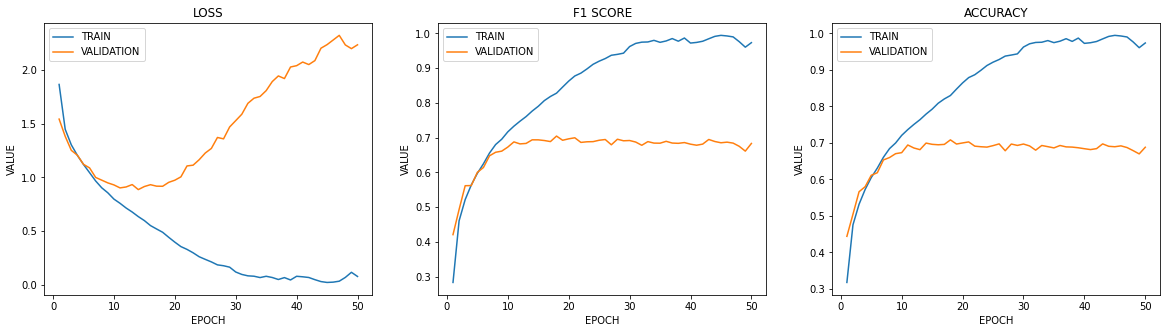


--------MODEL--------

Model2_dropout

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 384)               614784    
_________________________________________________________________
dropout_2 (Dro

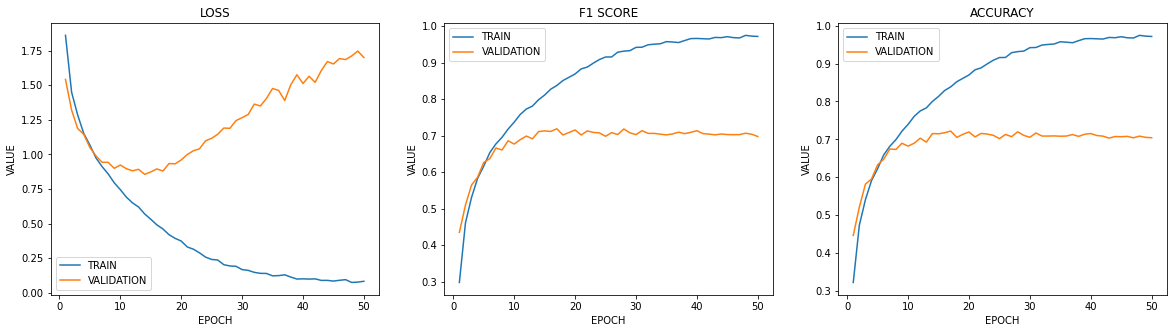


--------MODEL--------

Model3_l1

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 384)               614784    
_________________________________________________________________
dense_22 (Dense)   

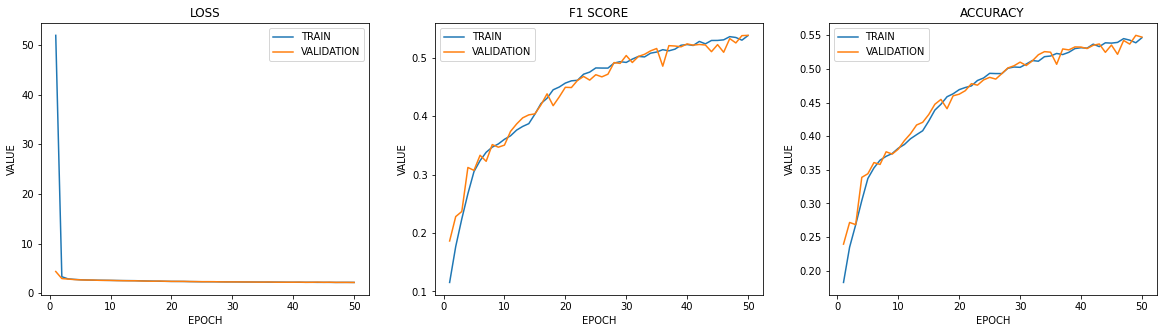


--------MODEL--------

Model4_depthwise

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_4 (Depthwis (None, 28, 28, 3)         78        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 3)         0         
_________________________________________________________________
depthwise_conv2d_5 (Depthwis (None, 10, 10, 3)         78        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 3)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 384)               29184     
_________________________________________________________________
dense_25 (De

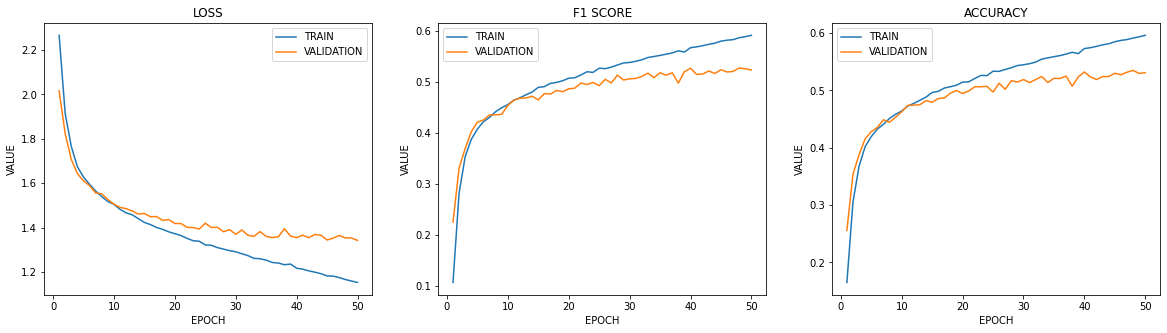

In [19]:
for model in trained_models:
  show_results(model)

### Test best model

In [20]:
model = trained_models[1]

--------MODEL--------

Model2_dropout

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 384)               614784    
_________________________________________________________________
dropout_2 (Drop

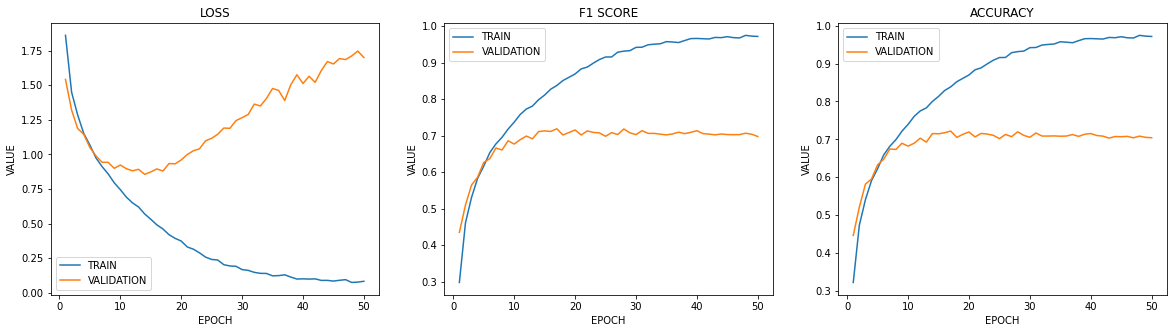

In [21]:
show_results(model)

In [22]:
model = model.model

In [23]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model.predict(test_ds['X'])

In [24]:
print('Test F1: '+str(f1score(y_true, y_pred_probs)))

Test F1: 0.7011389180687719


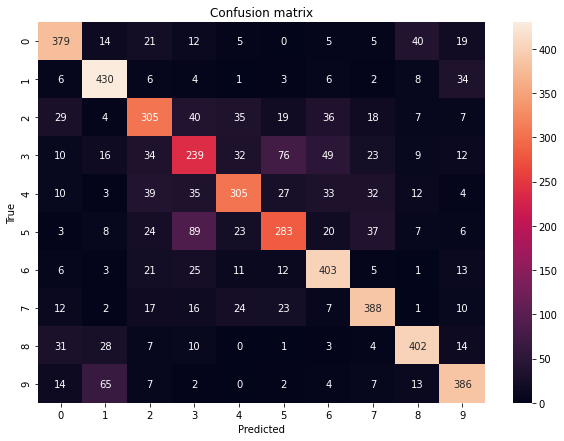

In [25]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

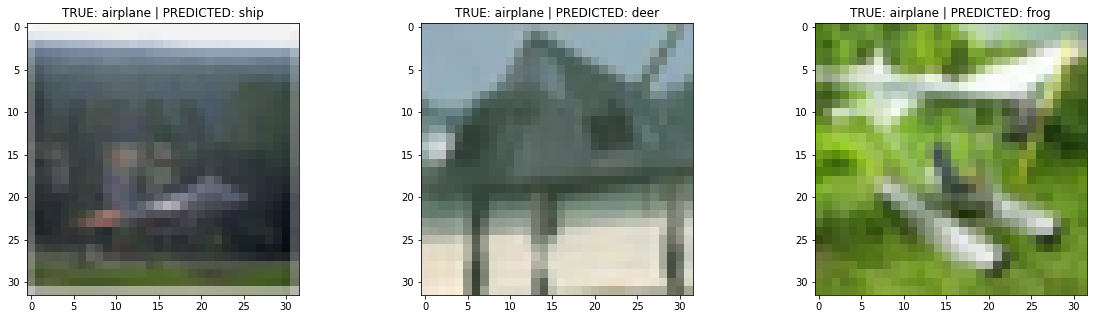

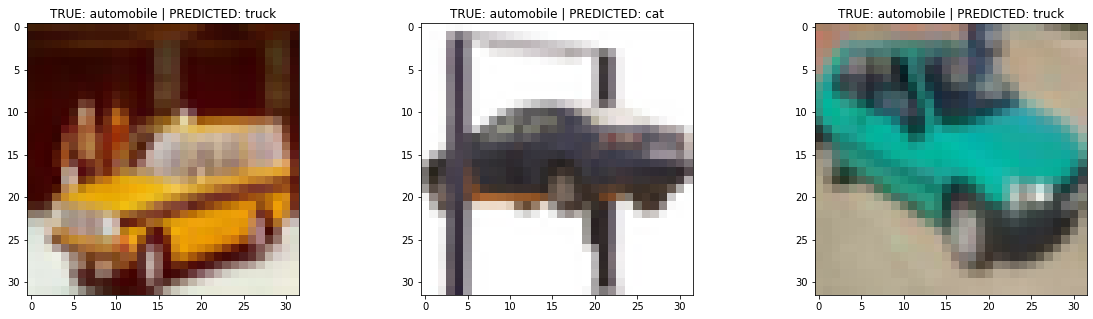

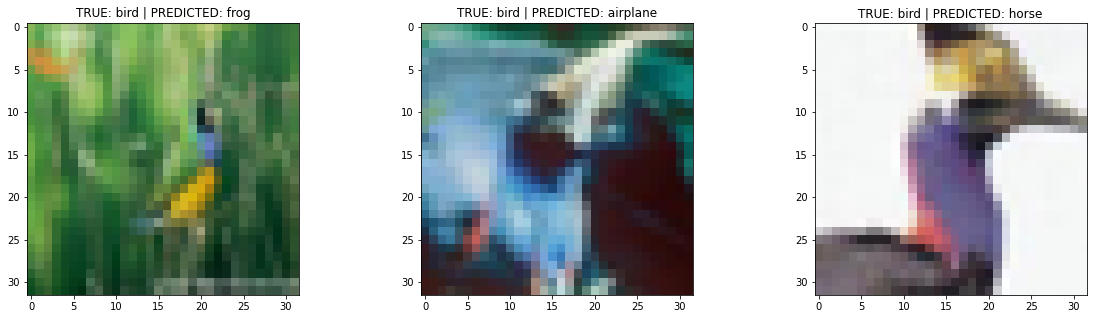

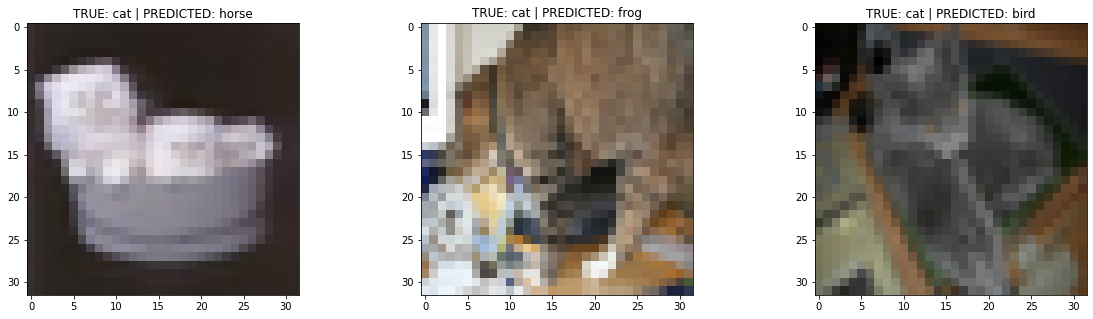

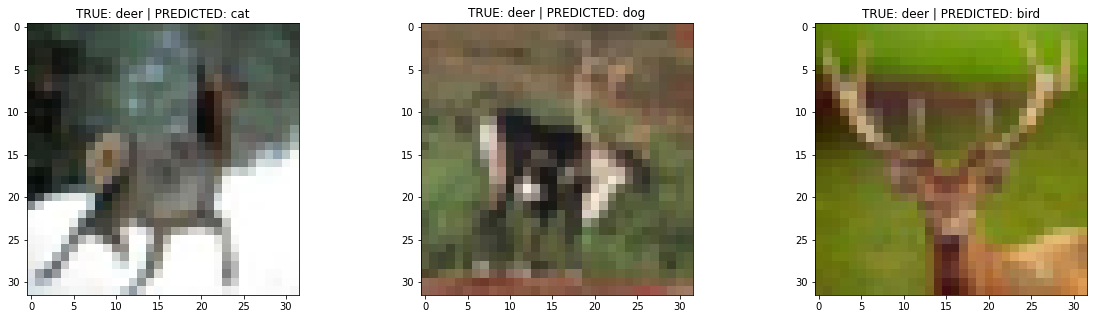

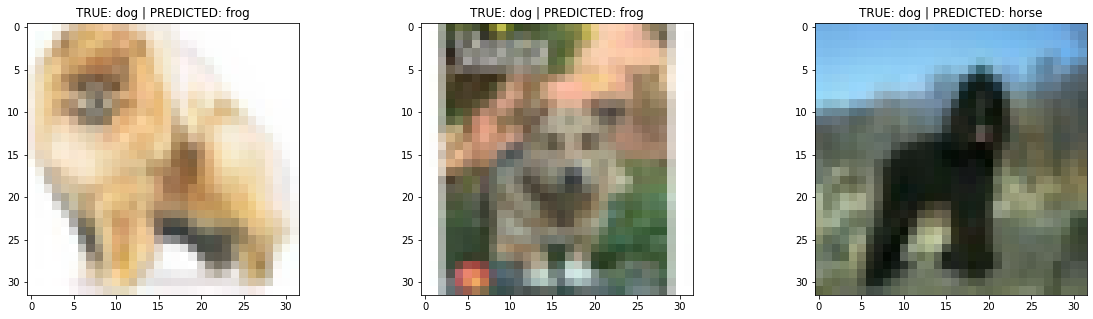

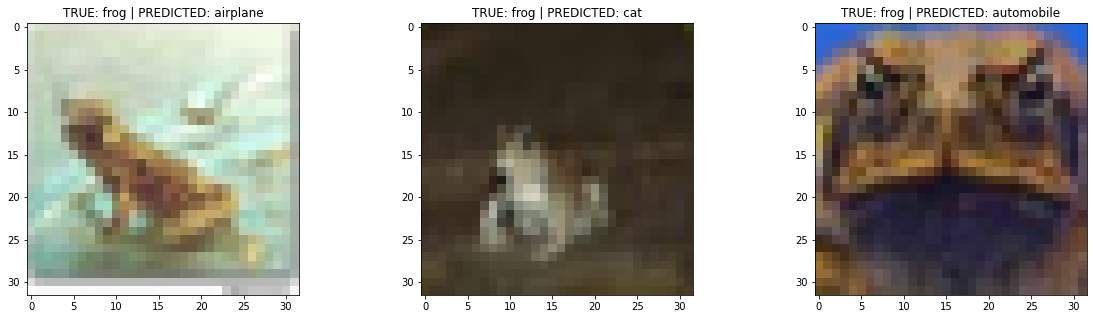

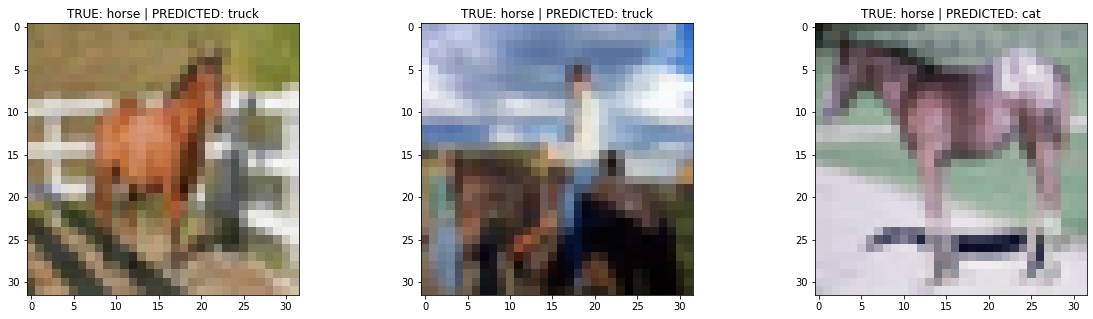

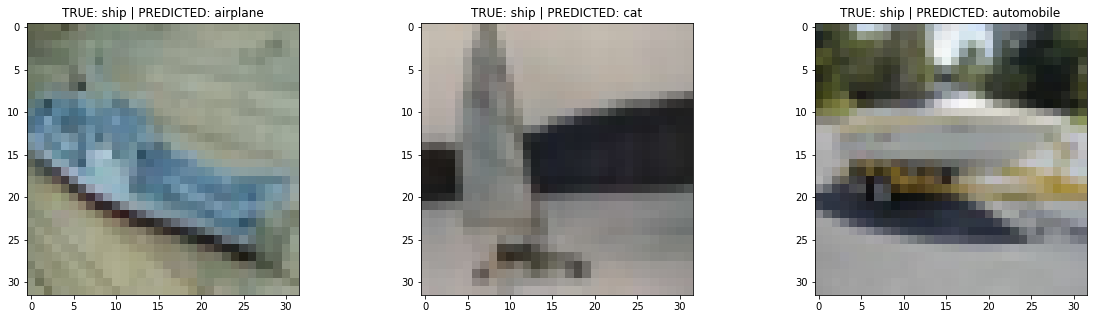

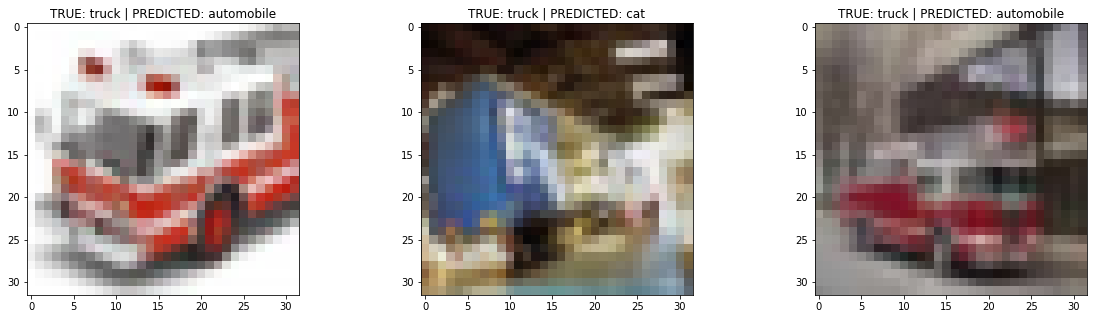

In [26]:
for i in range(10):
  plot_misclasified(i)

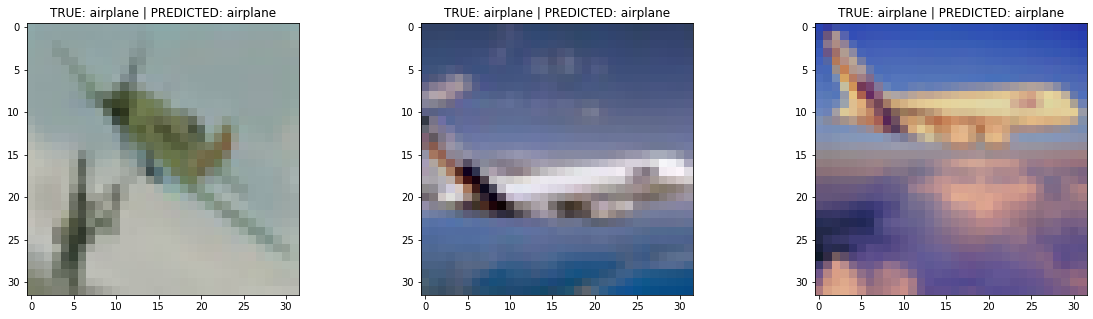

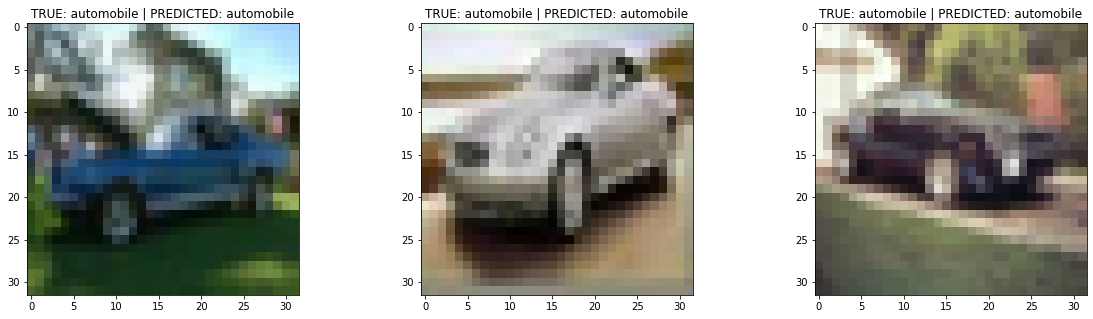

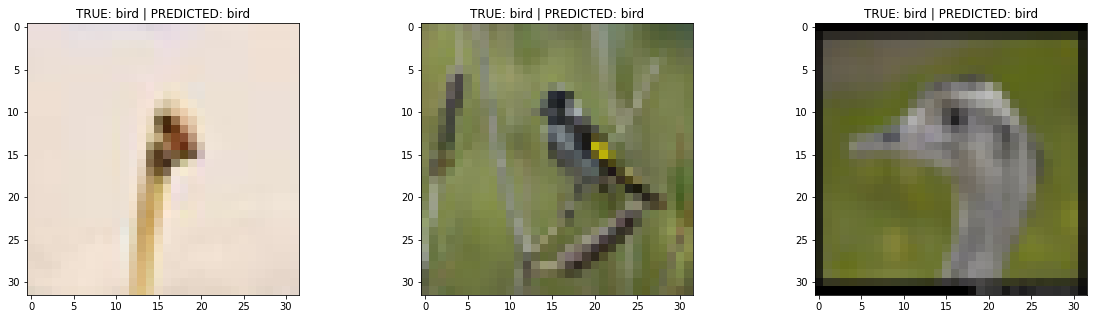

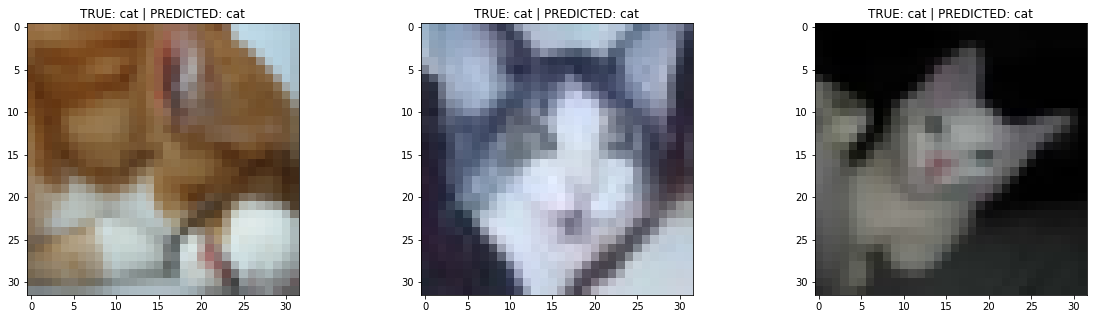

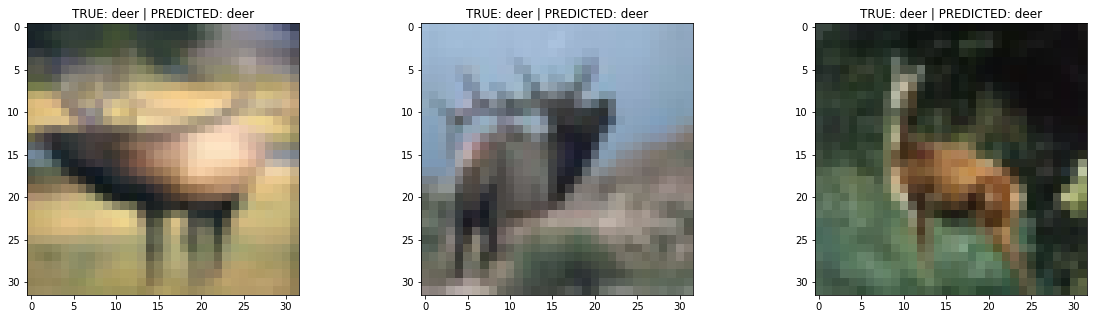

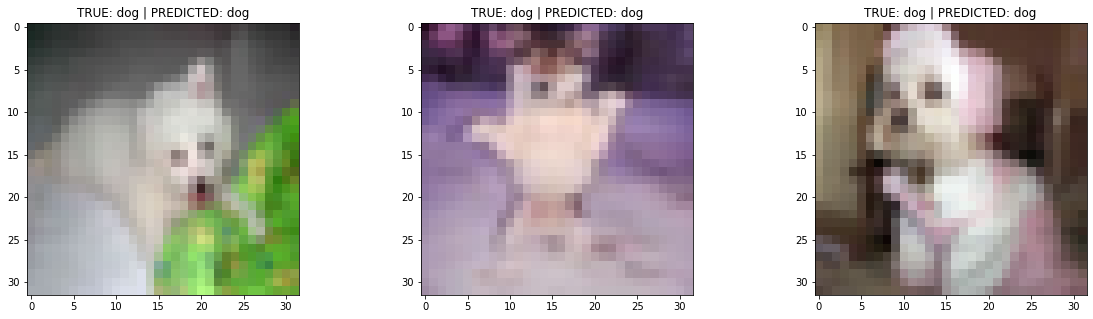

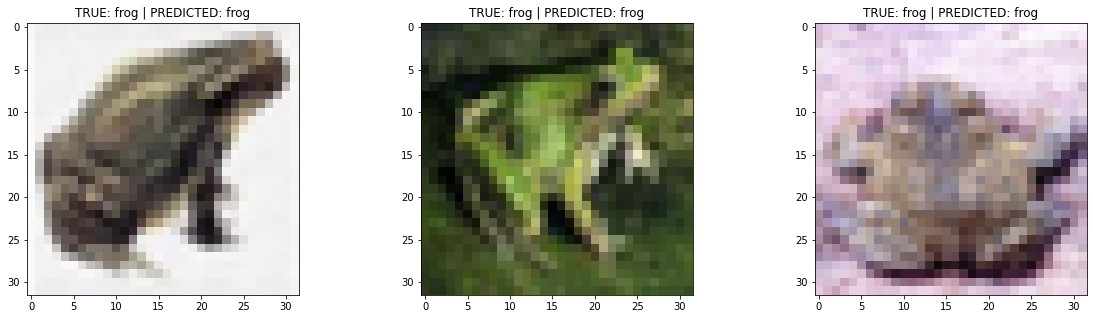

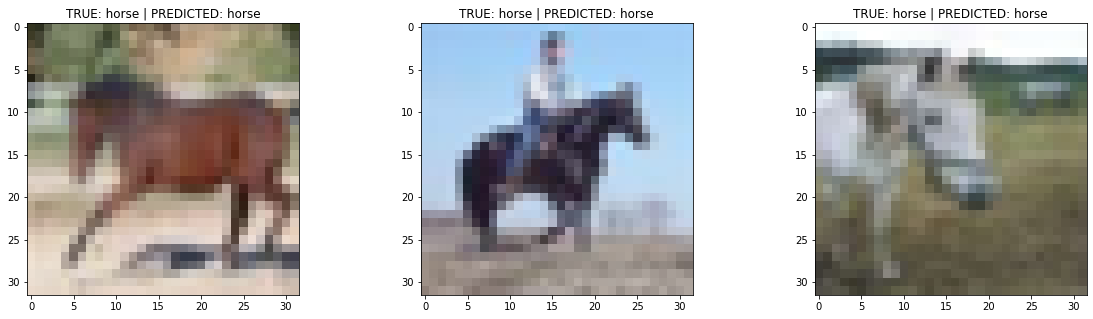

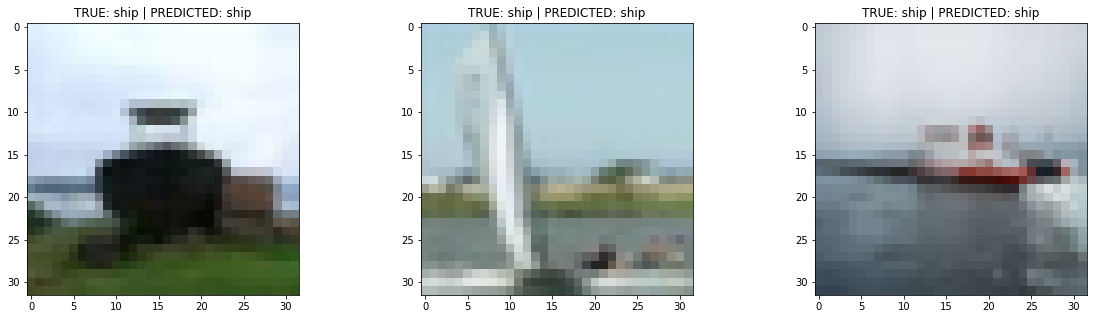

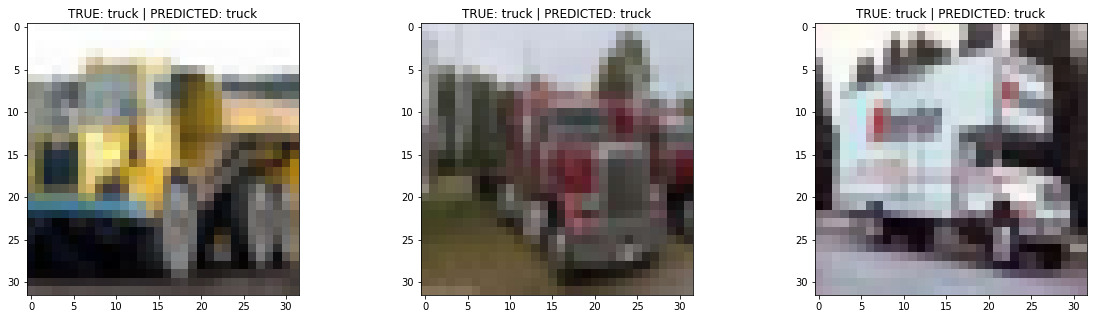

In [27]:
for i in range(10):
  plot_properclasified(i)